In [1]:
# Importing required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils import class_weight
import os, shutil, random, itertools, warnings
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Accessing the folders
train_dir = 'brain_tumor_dataset/Training'
test_dir = 'brain_tumor_dataset/Testing'

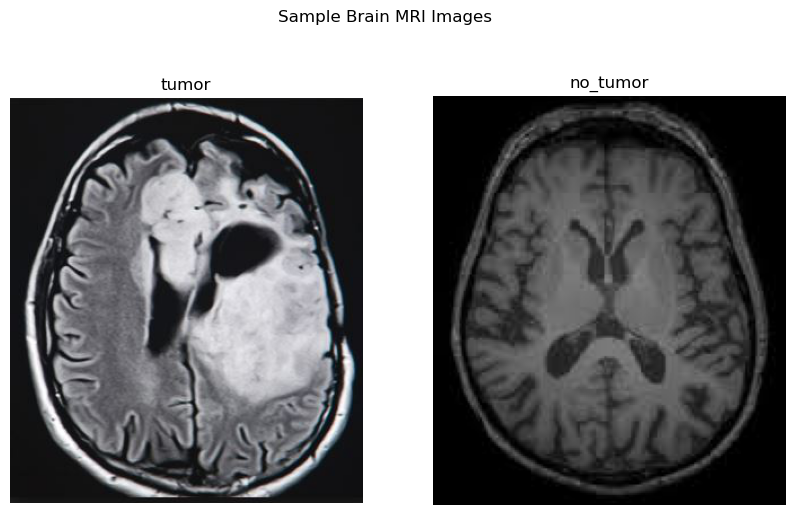

Tumor images: 155
No Tumor images: 98


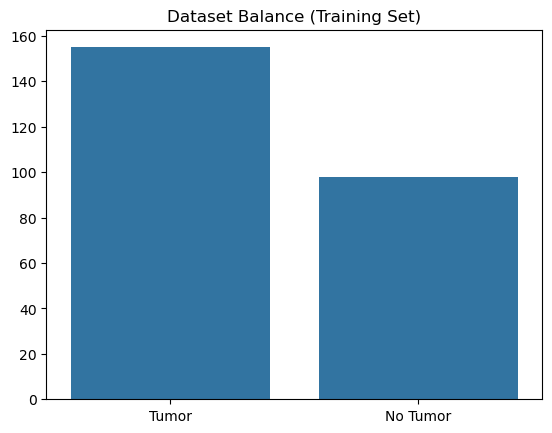

In [3]:
# Sample images from dataset
plt.figure(figsize=(10,6))
for i, label in enumerate(['tumor', 'no_tumor']):
    folder = os.path.join(train_dir, label)
    img_path = random.choice(os.listdir(folder))
    img = image.load_img(os.path.join(folder, img_path))
    plt.subplot(1,2,i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.suptitle("Sample Brain MRI Images")
plt.show()

# Dataset Balance
count_yes = len(os.listdir(os.path.join(train_dir, 'tumor')))
count_no = len(os.listdir(os.path.join(train_dir, 'no_tumor')))
print(f"Tumor images: {count_yes}")
print(f"No Tumor images: {count_no}")

sns.barplot(x=['Tumor', 'No Tumor'], y=[count_yes, count_no])
plt.title("Dataset Balance (Training Set)")
plt.show()

In [4]:
# Augmentation and Normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir, target_size=(224,224), batch_size=32,
    class_mode='binary', subset='training'
)
val_data = train_datagen.flow_from_directory(
    train_dir, target_size=(224,224), batch_size=32,
    class_mode='binary', subset='validation'
)
test_data = test_datagen.flow_from_directory(
    test_dir, target_size=(224,224), batch_size=32,
    class_mode='binary', shuffle=False
)

print(train_data.class_indices)
print(test_data.class_indices)

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 253 images belonging to 2 classes.
{'no_tumor': 0, 'tumor': 1}
{'no_tumor': 0, 'tumor': 1}


In [5]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [23]:
# Build a simple CNN model
cnn_model = Sequential([
    Input(shape=(224,224,3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()

# Train the CNN
history_cnn = cnn_model.fit(
    train_data,
    epochs=15,
    validation_data=val_data,
    callbacks=[early_stop]
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.5911 - loss: 0.6561 - val_accuracy: 0.6600 - val_loss: 0.5696
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.6355 - loss: 0.6230 - val_accuracy: 0.7200 - val_loss: 0.5649
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6650 - loss: 0.6144 - val_accuracy: 0.7200 - val_loss: 0.5514
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6847 - loss: 0.6045 - val_accuracy: 0.7000 - val_loss: 0.5707
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6502 - loss: 0.6086 - val_accuracy: 0.8000 - val_loss: 0.4843
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6798 - loss: 0.5782 - val_accuracy: 0.7200 - val_loss: 0.5328
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7389 - loss: 0.5835 - val_accuracy: 0.7600 - val_loss: 0.5108
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6897 - loss: 0.5854 - val_accuracy: 0.7000 - val_loss: 0.5321
Epoch 9/

In [24]:
# Improved ResNet50 Section
train_datagen_resnet = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)
test_datagen_resnet = ImageDataGenerator(preprocessing_function=preprocess_input)

train_data_resnet = train_datagen_resnet.flow_from_directory(
    train_dir, target_size=(224,224), batch_size=32,
    class_mode='binary', subset='training'
)
val_data_resnet = train_datagen_resnet.flow_from_directory(
    train_dir, target_size=(224,224), batch_size=32,
    class_mode='binary', subset='validation'
)
test_data_resnet = test_datagen_resnet.flow_from_directory(
    test_dir, target_size=(224,224), batch_size=32,
    class_mode='binary', shuffle=False
)

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 253 images belonging to 2 classes.


In [18]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in base_model.layers:
    layer.trainable = True

resnet_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data_resnet.classes),
    y=train_data_resnet.classes
)
class_weights = dict(enumerate(class_weights))

resnet_model.compile(optimizer=Adam(learning_rate=1e-5),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                 patience=3, min_lr=1e-7, verbose=1)

history_resnet = resnet_model.fit(
    train_data_resnet,
    epochs=25,
    validation_data=val_data_resnet,
    class_weight=class_weights,
    callbacks=[early_stop, lr_scheduler]
)

Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 235s 26s/step - accuracy: 0.4680 - loss: 0.9713 - val_accuracy: 0.4400 - val_loss: 0.8390 - learning_rate: 1.0000e-05
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 155s 21s/step - accuracy: 0.5369 - loss: 0.8185 - val_accuracy: 0.4200 - val_loss: 0.8214 - learning_rate: 1.0000e-05
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 161s 26s/step - accuracy: 0.5222 - loss: 0.8272 - val_accuracy: 0.5000 - val_loss: 0.7627 - learning_rate: 1.0000e-05
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 121s 17s/step - accuracy: 0.5074 - loss: 0.9047 - val_accuracy: 0.5000 - val_loss: 0.7811 - learning_rate: 1.0000e-05
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 107s 15s/step - accuracy: 0.6256 - loss: 0.7085 - val_accuracy: 0.5400 - val_loss: 0.7039 - learning_rate: 1.0000e-05


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 327ms/step
CNN MODEL PERFORMANCE
              precision    recall  f1-score   support

    No Tumor       0.79      0.55      0.65        98
       Tumor       0.76      0.91      0.83       155

    accuracy                           0.77       253
   macro avg       0.78      0.73      0.74       253
weighted avg       0.77      0.77      0.76       253

ROC-AUC: 0.8215931533903884


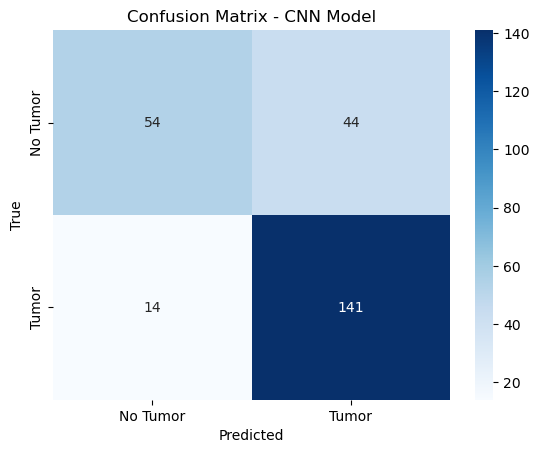

8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step
Best Threshold: 0.37662187
RESNET50 MODEL PERFORMANCE (Improved)
              precision    recall  f1-score   support

    No Tumor       0.50      0.53      0.52        98
       Tumor       0.69      0.67      0.68       155

    accuracy                           0.62       253
   macro avg       0.60      0.60      0.60       253
weighted avg       0.62      0.62      0.62       253

ROC-AUC: 0.6031599736668861


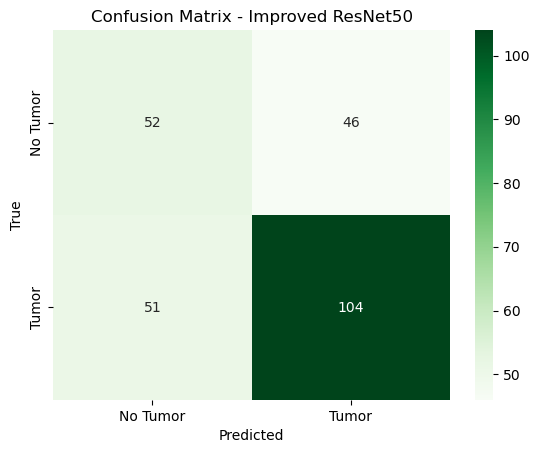

In [25]:
# CNN Confusion Matrix and Performance
y_true_cnn = test_data.classes
y_pred_prob_cnn = cnn_model.predict(test_data)
y_pred_cnn = (y_pred_prob_cnn > 0.5).astype(int).ravel()

print("CNN MODEL PERFORMANCE")
print(classification_report(y_true_cnn, y_pred_cnn, target_names=['No Tumor', 'Tumor']))
print("ROC-AUC:", roc_auc_score(y_true_cnn, y_pred_prob_cnn))

cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.title('Confusion Matrix - CNN Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ResNet50 Confusion Matrix and Performance
y_true_resnet = test_data_resnet.classes
y_pred_prob_resnet = resnet_model.predict(test_data_resnet)
fpr, tpr, thresholds = roc_curve(y_true_resnet, y_pred_prob_resnet)
best_threshold = thresholds[np.argmax(tpr - fpr)]
print("Best Threshold:", best_threshold)

y_pred_resnet = (y_pred_prob_resnet > best_threshold).astype(int).ravel()

print("RESNET50 MODEL PERFORMANCE (Improved)")
print(classification_report(y_true_resnet, y_pred_resnet, target_names=['No Tumor', 'Tumor']))
print("ROC-AUC:", roc_auc_score(y_true_resnet, y_pred_prob_resnet))

cm_resnet = confusion_matrix(y_true_resnet, y_pred_resnet)
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.title('Confusion Matrix - Improved ResNet50')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

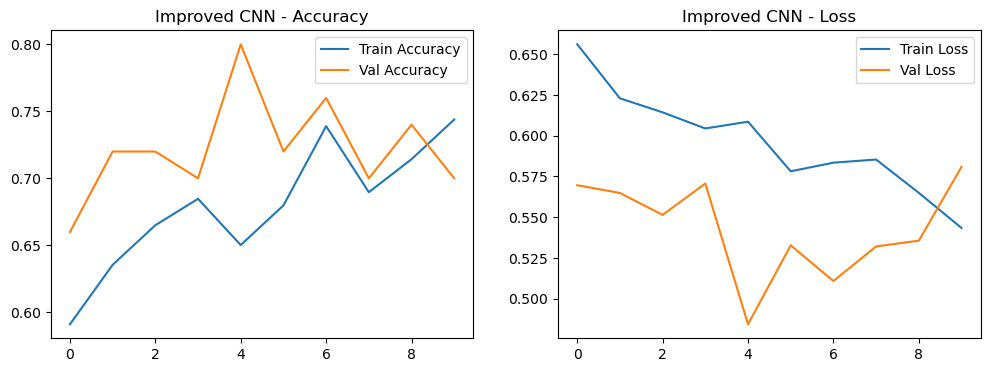

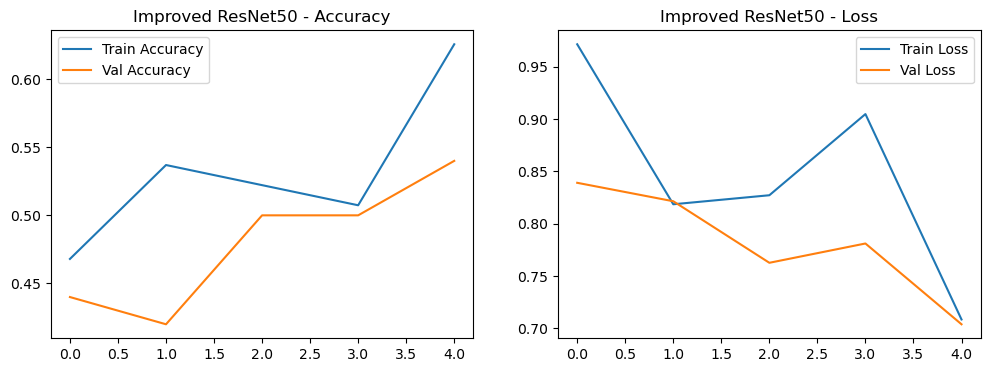

In [26]:
# Improved CNN Accuracy and Loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Val Accuracy')
plt.title('Improved CNN - Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.title('Improved CNN - Loss')
plt.legend()
plt.show()

# Improved ResNet50 Accuracy and Loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_resnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Val Accuracy')
plt.title('Improved ResNet50 - Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_resnet.history['loss'], label='Train Loss')
plt.plot(history_resnet.history['val_loss'], label='Val Loss')
plt.title('Improved ResNet50 - Loss')
plt.legend()
plt.show()


Displaying 3 Correct and 3 Incorrect Predictions for CNN Model:


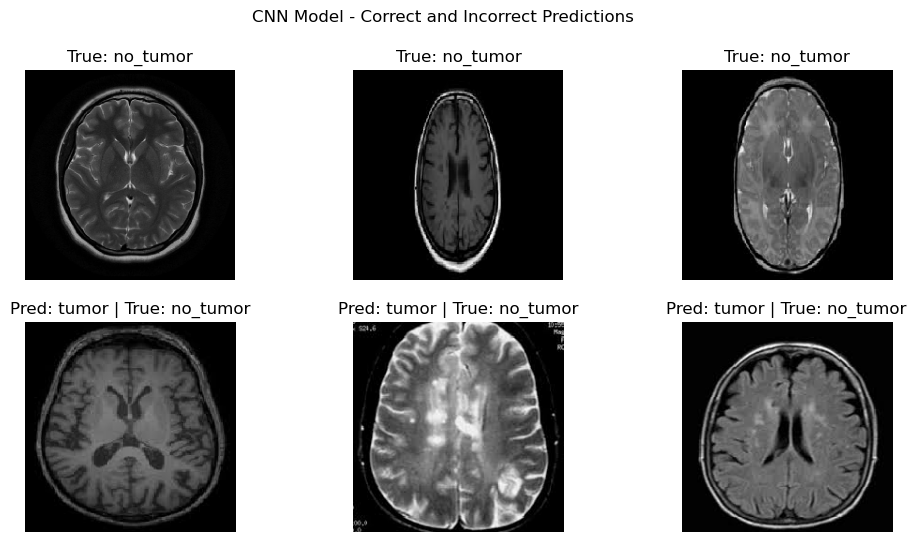


Displaying 3 Correct and 3 Incorrect Predictions for ResNet50 Model:


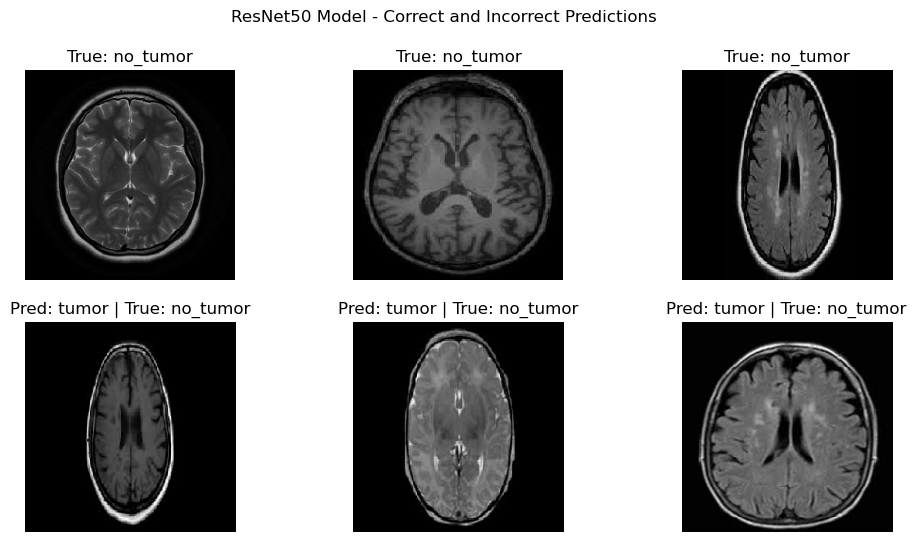

In [27]:
# Correct and Incorrect Predictions (CNN + ResNet50)
def show_predictions(model_name, test_gen, y_true, y_pred, num_correct=3, num_wrong=3):
    correct_indices = np.where(y_true == y_pred)[0]
    wrong_indices = np.where(y_true != y_pred)[0]

    print(f"\nDisplaying {num_correct} Correct and {num_wrong} Incorrect Predictions for {model_name}:")

    plt.figure(figsize=(12,6))
    for i, idx in enumerate(correct_indices[:num_correct]):
        img_path = test_gen.filepaths[idx]
        img = image.load_img(img_path, target_size=(224,224))
        plt.subplot(2, num_correct, i+1)
        plt.imshow(img)
        plt.title(f"True: {list(test_gen.class_indices.keys())[int(y_true[idx])]}") 
        plt.axis('off')

    for i, idx in enumerate(wrong_indices[:num_wrong]):
        img_path = test_gen.filepaths[idx]
        img = image.load_img(img_path, target_size=(224,224))
        plt.subplot(2, num_wrong, num_correct + i + 1)
        plt.imshow(img)
        plt.title(f"Pred: {list(test_gen.class_indices.keys())[int(y_pred[idx])]} | True: {list(test_gen.class_indices.keys())[int(y_true[idx])]}") 
        plt.axis('off')

    plt.suptitle(f"{model_name} - Correct and Incorrect Predictions")
    plt.show()

show_predictions("CNN Model", test_data, y_true_cnn, y_pred_cnn)
show_predictions("ResNet50 Model", test_data_resnet, y_true_resnet, y_pred_resnet)

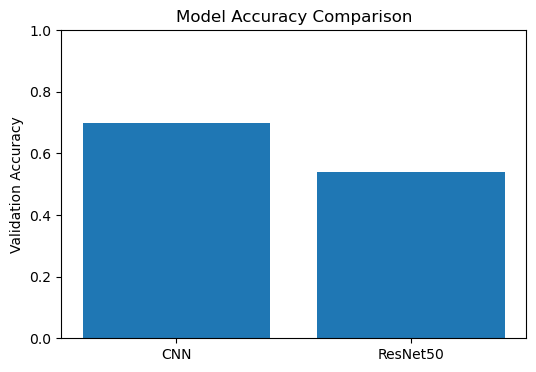

CNN Validation Accuracy: 0.7000
ResNet50 Validation Accuracy: 0.5400


In [28]:
cnn_accuracy = history_cnn.history['val_accuracy'][-1]
resnet_accuracy = history_resnet.history['val_accuracy'][-1]

models = ['CNN', 'ResNet50']
accuracies = [cnn_accuracy, resnet_accuracy]

plt.figure(figsize=(6,4))
plt.bar(models, accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Validation Accuracy')
plt.ylim(0, 1)
plt.show()

print(f"CNN Validation Accuracy: {cnn_accuracy:.4f}")
print(f"ResNet50 Validation Accuracy: {resnet_accuracy:.4f}")